<a href="https://colab.research.google.com/github/shravankoninti/AV/blob/master/Innoplex_Nvidia_23_03_2019_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#   process = psutil.Process(os.getpid())
#   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

In [0]:
RANDOM_STATE = 17

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import nltk

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#train.csv

# Download a file based on its file ID.
# https://drive.google.com/open?id=1A3BLkSn7GOwR7J2ccoIoDoQVOXLeytyR

file_id = '1A3BLkSn7GOwR7J2ccoIoDoQVOXLeytyR' #https://drive.google.com/open?id=1R72cIA1deLDdg0aULjcl5OR6tsv-DRaq
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('sample_submission.csv')

In [0]:
submission = pd.read_csv('sample_submission.csv', encoding = "ISO-8859-1")
submission.head()

In [0]:
submission.shape

In [0]:
#test.csv

file_id = '1A74kdE3pv_WvHJwuEbeF2TlYk4irXlis' #https://drive.google.com/open?id=1R72cIA1deLDdg0aULjcl5OR6tsv-DRaq
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test.csv')

In [11]:
test_df = pd.read_csv('test.csv', encoding = "ISO-8859-1")
test_df.head(20)

,id,Doc_ID,Sent_ID,Word
0,4543834,30001,191283,CCCVA
1,4543835,30001,191283,","
2,4543836,30001,191283,MANOVA
3,4543837,30001,191283,","
4,4543838,30001,191283,my
5,4543839,30001,191283,black
6,4543840,30001,191283,hen
7,4543841,30001,191283,.
8,4543842,30001,191284,Comments
9,4543843,30001,191284,on


In [12]:
test_df.shape

(2994463, 4)

In [0]:
#train.csv

# Download a file based on its file ID.

file_id = '1R72cIA1deLDdg0aULjcl5OR6tsv-DRaq' #https://drive.google.com/open?id=1R72cIA1deLDdg0aULjcl5OR6tsv-DRaq
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.csv')

In [14]:
train_df = pd.read_csv('train.csv', encoding = "ISO-8859-1")
train_df.head()

,id,Doc_ID,Sent_ID,Word,tag
0,1,1,1,Obesity,O
1,2,1,1,in,O
2,3,1,1,Low-,O
3,4,1,1,and,O
4,5,1,1,Middle-Income,O


In [15]:
train_df.isnull().sum()

id           0
Doc_ID       0
Sent_ID      0
Word       130
tag          0
dtype: int64

## Data Preprocessing

In [0]:
train_df = train_df.fillna(method='ffill')
print(train_df.Sent_ID.nunique(), train_df.Word.nunique(), train_df.tag.nunique())

test_df = test_df.fillna(method='ffill')
print(test_df.Sent_ID.nunique(), test_df.Word.nunique())



In [0]:
train_df.isnull().sum()

We have 191,282 sentences that contain 184,505 unique words and tagged by 3 tags.

The tags are not evenly distributed.

In [0]:
train_df.groupby('tag').size().reset_index(name='counts')

In [0]:
test_df.isnull().sum()

In [0]:
import nltk
nltk.download('all')

In [0]:
# train_df['POS_full'] = nltk.pos_tag(train_df['Word']) 
test_df['POS_full'] = nltk.pos_tag(test_df['Word']) 

In [0]:
test_df.head(10)

In [0]:
# train_df['POS'] = train_df['POS_full'].apply(lambda x: x[1] )
test_df['POS'] = test_df['POS_full'].apply(lambda x: x[1] )

In [0]:
test_df.head(10)

In [0]:
# train_df = train_df.drop(['Doc_ID', 'POS_full','id'], axis= 1)
test_df = test_df.drop(['Doc_ID', 'POS_full','id'], axis= 1)

The following code transform the text date to vector using DictVectorizer and then split to train and test sets.

In [0]:
test_df.head(10)

In [0]:
train_df.Sent_ID.nunique(), train_df.Word.nunique(), train_df.POS.nunique()

In [0]:
test_df.Sent_ID.nunique(), test_df.Word.nunique(), test_df.POS.nunique()

In [0]:
test_df.isnull().sum()

In [0]:
test_df.columns

In [0]:
# test_df.to_csv('test_df_mod.csv')

In [16]:
# train_df.to_csv('train_df_mod.csv')
# https://drive.google.com/open?id=1SGZAB97aRcYs0Vih40R23Cua9lRshsy0

file_id = '1SGZAB97aRcYs0Vih40R23Cua9lRshsy0'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_df_mod.csv')

file_id = '1t3v5g_C99p8cXUVXCEIr98oojVmeTc9J'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_df_mod.csv')

train_df = pd.read_csv('train_df_mod.csv')
test_df = pd.read_csv('test_df_mod.csv')

train_df = train_df[['Sent_ID', 'Word', 'tag', 'POS']]

# train_df = train_df[:55000]
print(train_df.shape)


test_df = test_df[['Sent_ID', 'Word',  'POS']]
print(test_df.shape)

(4543833, 4)
(2994463, 3)


In [0]:
# X = train_df.drop('tag', axis=1)
# v = DictVectorizer(sparse=False)
# X = v.fit_transform(X.to_dict('records'))
# y = train_df.tag.values
# classes = np.unique(y)
# classes = classes.tolist()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=17)
# X_train.shape, y_train.shape

In [0]:
per = Perceptron(verbose=10, n_jobs=-1, max_iter=5)
per.partial_fit(X_train, y_train, classes)


In [0]:
new_classes = classes.copy()
new_classes.pop()
new_classes

In [0]:
print(classification_report(y_pred=per.predict(X_test), y_true=y_test, labels=new_classes))

In [0]:
sgd = SGDClassifier()
sgd.partial_fit(X_train, y_train, classes)

In [0]:
print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels=new_classes))

In [0]:
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(X_train, y_train, classes)

In [0]:
print(classification_report(y_pred=nb.predict(X_test), y_true=y_test, labels = new_classes))

In [0]:
pa =PassiveAggressiveClassifier()
pa.partial_fit(X_train, y_train, classes)

In [0]:
print(classification_report(y_pred=pa.predict(X_test), y_true=y_test, labels=new_classes))

In [7]:
!pip install sklearn_crfsuite

    100% |████████████████████████████████| 757kB 11.5MB/s 


In [9]:
# train_df.to_csv('train_df_mod.csv')
# https://drive.google.com/open?id=1SGZAB97aRcYs0Vih40R23Cua9lRshsy0

file_id = '1SGZAB97aRcYs0Vih40R23Cua9lRshsy0'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_df_mod.csv')

file_id = '1t3v5g_C99p8cXUVXCEIr98oojVmeTc9J'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_df_mod.csv')

train_df = pd.read_csv('train_df_mod.csv')
test_df = pd.read_csv('test_df_mod.csv')

train_df = train_df[['Sent_ID', 'Word', 'tag', 'POS']]

train_df = train_df[:4200000]
print(train_df.shape)


test_df = test_df[['Sent_ID', 'Word',  'POS']]
print(test_df.shape)

(4543833, 4)
(2994463, 3)


In [0]:
# !pip install sklearn_crfsuite

In [0]:
# import sklearn_crfsuite
# from sklearn_crfsuite import scorers
# from sklearn_crfsuite import metrics
# from collections import Counter

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['tag'].values.tolist())]
        self.grouped = self.data.groupby('Sent_ID').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None
getter = SentenceGetter(train_df)
sentences = getter.sentences

In [14]:
print(sentences[0:1])

[[('Obesity', 'NN', 'O'), ('in', 'IN', 'O'), ('Low-', 'NNP', 'O'), ('and', 'CC', 'O'), ('Middle-Income', 'JJ', 'O'), ('Countries', 'NNS', 'O'), (':', ':', 'O'), ('Burden', 'NNP', 'O'), (',', ',', 'O'), ('Drivers', 'NNP', 'O'), (',', ',', 'O'), ('and', 'CC', 'O'), ('Emerging', 'NNP', 'O'), ('Challenges', 'NNP', 'O'), ('.', '.', 'O')]]


In [15]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 3899


In [0]:
class SentenceGetter_test(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p) for w, p in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           )]
        self.grouped = self.data.groupby('Sent_ID').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None
getter_test = SentenceGetter_test(test_df)
sentences_test = getter_test.sentences

In [17]:
maxlen = max([len(s) for s in sentences_test])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 3881


In [0]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

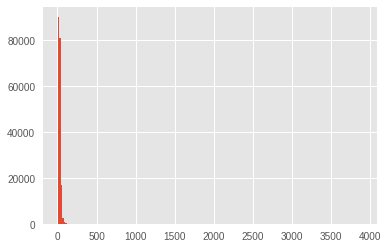

In [19]:
plt.hist([len(s) for s in sentences], bins=200)
plt.show()

In [0]:
words = list(set(train_df["Word"].values))
words.append("ENDPAD")

words_test = list(set(test_df["Word"].values))
words_test.append("ENDPAD")

In [21]:
n_words = len(words); n_words
n_words_test = len(words_test); n_words_test

139892

In [22]:
tags = list(set(train_df["tag"].values))
n_tags = len(tags); n_tags

3

In [0]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

word2idx_test = {w: i for i, w in enumerate(words_test)}


In [24]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]


from keras.preprocessing.sequence import pad_sequences
test_X = [[word2idx_test[w[0]] for w in s] for s in sentences_test]

Using TensorFlow backend.


In [0]:
X = pad_sequences(maxlen=3899, sequences=X, padding="post",value=n_words - 1)
test_X = pad_sequences(maxlen=3899, sequences=test_X, padding="post",value=n_words_test - 1)

In [26]:
len(X)

191282

In [27]:
len(test_X)

125840

In [0]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [0]:
y = pad_sequences(maxlen=3899, sequences=y, padding="post", value=tag2idx["O"])

In [0]:

# del [[train_df,test_df]]
# import gc
# import resource
# gc.collect()
# train_df=pd.DataFrame()
# test_df=pd.DataFrame()
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [0]:
len(X), len(y)

In [0]:
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

input = Input(shape=(3899,))
model = Embedding(input_dim=n_words, output_dim=3899, input_length=3899)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [0]:
model = Model(input, out)

In [0]:
len(X_train), len(y_train)

In [0]:
len(X_test), len(y_test)

In [0]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1,  verbose=1)

In [0]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(words[w],tags[pred]))

In [0]:
len(test_X)

In [0]:
i = 0
p1 = model.predict(np.array([test_X[i]]))
p1 = np.argmax(p1, axis=-1)

for w,pred in zip(test_X[i],p1[0]):
  print("{:15}: {}".format(words_test[w],tags[pred]))    

In [0]:
submission['tag'].value_counts()

In [0]:
submission.head(3)

In [0]:
# def word2features(sent, i):  
#   word = sent[i][0]
#   postag = sent[i][1]

#   features = {
#       'bias': 1.0, 
#       'word.lower()': word.lower(), 
#       'word[-3:]': word[-3:],
#       'word[-2:]': word[-2:],
#       'word.isupper()': word.isupper(),
#       'word.istitle()': word.istitle(),
#       'word.isdigit()': word.isdigit(),
#       'postag': postag,
#       'postag[:2]': postag[:2],
#   }
#   if i > 0:
#       word1 = sent[i-1][0]
#       postag1 = sent[i-1][1]
#       features.update({
#           '-1:word.lower()': word1.lower(),
#           '-1:word.istitle()': word1.istitle(),
#           '-1:word.isupper()': word1.isupper(),
#           '-1:postag': postag1,
#           '-1:postag[:2]': postag1[:2],
#       })
#   else:
#       features['BOS'] = True
#   if i < len(sent)-1:
#       word1 = sent[i+1][0]
#       postag1 = sent[i+1][1]
#       features.update({
#           '+1:word.lower()': word1.lower(),
#           '+1:word.istitle()': word1.istitle(),
#           '+1:word.isupper()': word1.isupper(),
#           '+1:postag': postag1,
#           '+1:postag[:2]': postag1[:2],
#       })
#   else:
#       features['EOS'] = True
#       return features



In [0]:

# def sent2features(sent):
#     return [word2features(sent, i) for i in range(len(sent))]
# def sent2labels(sent):
#     return [label for token, postag, label in sent]
# def sent2tokens(sent):
#     return [token for token, postag, label in sent]

In [0]:
# X = [sent2features(s) for s in sentences]
# y = [sent2labels(s) for s in sentences]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [0]:
# crf = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
#     c1=0.1,
#     c2=0.1,
#     max_iterations=100,
#     all_possible_transitions=True
# )
# crf.fit(X_train, y_train)